# Project: Decision Trees

## Machine Learning, Winter 2017

### Name: Neel Shroff, Alex Davenport, Tony Tan, Gherardo Morona


In this project, you'll perform the following tasks:
1. Construct a (Python) class `DecisionTree` which will serve as our first machine learning model.
2. Test it out on multiple datasets.  If you've done the above correctly, this shouldn't be hard!
3. Determine the effects of overfitting and attempt some solutions, discussing which seem to work best.

### Import Statements

In [1]:
# Standard import statements:
from itertools import combinations, chain
from statistics import mean, median
from operator import itemgetter
from sklearn.datasets import make_blobs, load_iris
from sklearn.model_selection import train_test_split


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, precision_score, recall_score

%matplotlib inline

plt.style.use("ggplot")

## `DecisionTree` Class

Construct a `DecisionTree` class in the cell below.  It should support the standard scikit-learn API: 

```
>>> X, y = <your_dataset>
>>> model = DecisionTree() # potentially with some parameters, if needed
>>> model.fit(X,y)
>>> model.predict(<new_sample_vector>)
1
>>> # If the model predicted your sample vector to be in class 1.
```

Note that your `predict` function should support either single predictions or multiple predictions, though you can force the user to do single predictions as a 2d array (single-row "multiple" predictions) so you only have one implementation to write.  What I mean by this is `model.predict(X)` should work (without error) to create all predictions for `y`.

You should construct some human-readable visualization of your model, simply from a printout.  This way you can tell if the model is being built the way you want.  The best way to do this is to implement the `__str__` method for your class.  Probably the easiest way to do this is to iterate through the tree in a "depth-first" fashion, and for each node, just print out some basic facts, like the number of elements in that node, or the indices of those elements in `X`, and the class assignment if it's a leaf node; also, make sure the indentation level of each node increases as its depth increases.  It might be helpful to have your nodes be more than just the bare minimum object (which would probably be a list of the indices of the rows in `X` for the items in your node).  To reiterate: this should NOT be a "beautiful" printout with lines like:
```
            root
           /    \
     child1      child2 
    /      \    /      \
...
```

Because that would get awkward fast.  What I'm imagining is:

```
root: <root_info>
  child1: <child1_info>
    grandchild1: <grandchild1_info>
      ...
    grandchild1: <grandchild2_info>
      ...
  child2: <child2_info>
    grandchild1: <grandchild1_info>
    grandchild1: <grandchild2_info>
```

By implementing this in `__str__` for your class, this will be the printout when you run:

```
model = DecisionTree(<whatever_you_need_to_do_to_create_your_model>)
model.fit(X,y)
print(model)
```

Recall the algorithm for fitting a decision tree:
1. Start with all your data samples in a single node.
2. For a given node, determine if you want to split at that node or not.  For now, this should just be a check to see if the node is "pure", meaning it only contains one class.  If you do decide to split it further, compute all possible splits of your data (all possible depth-1 subtrees).  For categorical variables, this should look like generating all pairs of combinations of classes.  For continuous or ordinal variables, sort the entries in that column, and then all possible splits involve cutting off at values between adjacent entries.  That is, if the entries in my continuous column are `[2.01, 3.425, 8.67, 493.6]`, then I have three splits, which are 
"$x_i\leq 2.01$", "$x_i\leq 3.425$", "$x_i\leq 8.67$".
3. Compute the change in Gini Impurity for each split, and choose the split that has the largest gain in information (most pure nodes).  Recall that the Gini Impurity for a node is 
$$ I = 1 - \sum_{\text{each class}} \left(\frac{\text{# of elements in that class}}{\text{# of elements in the node}}\right)^2$$
So then you want to minimize $I_\text{new_child1} + I_\text{new_child2} - I_\text{old}$; that is, choose the split with the largest value for that quantity (roughly interpretted as "information gain", though for the record the term "information gain" is used in a totally-synonymous-but-technically-different situation).
4. Repeat until all nodes are pure.
5. (Get the above working first, and then later:) prune the tree back to avoid overfitting your training data. (See below)

Note that your (Python) class should work for multi-class datasets (where you're trying to predict a `y` that has more than two classes).

## Tree Class

Along with the `__init__` method, the class has 7 other methods:
 * `fit`: Creates the a model for the dataset.
 * `predict`: Responsible for predicting the classes for a list of predictions.
 * `calculate_gini`: Calculates the Gini impurity of the given node.
 * `find_best_split`: Finds best split.
 * `fitter`: Complements the fit method.
 * `show`: Helps implement the visual representation.
 * `__str__`: String representation of the tree.

In [2]:
class Tree:
    def __init__(self, x=None):
        self.tree = x
    
    def fit(self, X, y, n=10):
        # Inputs:
        # n : the limit for the number of nodes the tree will have predictors/class are dataframes with same indexing
        # X and y: dataframes
        # Sets tree to a list with left node, right node, threshold, predictor, and count.
        self.tree = self.fitter(X, y, n)
        return
    
    def predict(self, X_predict):
    # input: X_predict (which is a dataframe)
    # returns a list with each item bui;ding the prediction for each row of the X_predict dataframe
        class_predictions = []
        node1 = self.tree
        node = node1
        for prediction in X_predict.iterrows():
            row = prediction[1]
            while len(node) > 1:
                if row[node[2][0]] <= node[2][1]:
                    node = node[0]
                else:
                    node = node[1]
            class_predictions.append(node)
            node = node1
        return class_predictions
    
    def calculate_gini(self, P):
        # Input: a list of classes, such as ['S', 'NS', 'NS', 'NS', 'S'] or [0,1,0,2,1,0] if 0,1,2 are the things
        # that corresponds to an increasing list of some parameter that you want to split by.
        # Returns: gini score.
        # Used by: get_possible_splits().
        classes = list(set(P))  # find all the classes
        gini = 1
        for i in classes:
            gini -= (float(P.count(i)) / len(P)) ** 2
        return gini

    def find_best_split(self, node_x, node_y):
        # Returns the best split (threshold).
        gp = self.calculate_gini(list(node_y.values.flatten()))
        poss_splits = []
        for pred in node_x.columns:
            set_list = list(node_x[pred].unique())
            set_list.sort()
            for t in set_list[:-1]:
                downside = list(node_y[node_x[pred] <= t].values.flatten())
                upside = list(node_y[node_x[pred] > t].values.flatten())
                #print(list(downside))
                #print(list(upside))
                ig = gp - (
                    (len(downside) / len(node_y)) * self.calculate_gini(downside)
                    + (len(upside) / len(node_y)) * self.calculate_gini(upside))
                poss_splits.append((pred, t, ig, gp))
        try:
            return max(poss_splits, key=itemgetter(2))
        except:
            return None

    def fitter(self, X, y, n, branch=True):
        #print("Running fit")
        # Inputs:
        # n : the limit for the number of nodes the tree will have predictors/class are dataframes with same indexing
        # X and y: dataframes
        # Returns: a list with left node, right node, threshold

        if n == 0:
            return list([y.value_counts().idxmax()])

        n -= 1
        node = [[], [], []]
        tup = self.find_best_split(X, y)

        if tup != None:
            predictor, threshold, info_gain, gini = tup
        else:
            return list(y.unique())

        if gini <= 0.0001:  # if the node is pure (gini impurity is 0), then stop
            return list(y.unique())

        node[0] = self.fitter(X[X[predictor] <= threshold], y[X[predictor] <= threshold], n=n, branch=True)
        node[1] = self.fitter(X[X[predictor] > threshold], y[X[predictor] > threshold], n=n, branch=False)
        node[2] = (predictor,threshold,len(y))

        return node
    
    def show(self, tree, n=0):
        # Used to create the visual representation of the tree.
        spacing = ""
        for i in range(n):
            spacing += "   "
        if n == 0:
            spacing += "root: "
        elif n == 1:
            spacing += "child: "
        elif n > 1:
            spacing += "grandchild^" + str(n-1) + ": "
        if len(tree) == 3:
            print(spacing, "predictor:", tree[2][0], "| threshold:", tree[2][1], "| # elements:", tree[2][2])
            n += 1
            self.show(tree[0], n)
            self.show(tree[1], n)
        else:
            print(spacing, "class of leaf:", str(tree[0]))
            return
    
    def __str__(self):
        self.show(self.tree)
        return " "

To test out your code, here's a simple dataset.  You could check it by hand if you need to debug.  You're trying to predict whether an animal is a mammal or not (the class label).

In [3]:
X = [["human", "warm-blooded", "yes", "no", "no", "yes"],
     ["pigeon", "warm-blooded", "no", "no", "no", "no"],
     ["elephant", "warm-blooded", "yes", "yes", "no", "yes"],
     ["leopard shark", "cold-blooded", "yes", "no", "no", "no"],
     ["turtle", "cold-blooded", "no", "yes", "no", "no"],
     ["penguin", "cold-blooded", "no", "no", "no", "no"],
     ["eel", "cold-blooded", "no", "no", "no", "no"],
     ["dolphin", "warm-blooded", "yes", "no", "no", "yes"],
     ["spiny anteater", "warm-blooded", "no", "yes", "yes", "yes"],
     ["gila monster", "cold-blooded", "no", "yes", "yes", "no"]]

df = pd.DataFrame(X, columns = ["Name", 
                                "Body Temperature", 
                                "Gives Birth", 
                                "Four-legged", 
                                "Hibernates", 
                                "Class Label"])

## Try it out on multiple datasets

Feel free to split these amongst your group mates, then consolodate it into one notebook.

1. The dataset `X` above.

2. To double check that your multi-class support is working, use the [iris dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris).  Plot some decision boundaries of the classifier you make in all the pairs of dimensions in your scatter plots.

3. Take a look at some of the [dataset constructors in scikit-learn](http://scikit-learn.org/stable/datasets/#sample-generators).  Pick one that will allow you to generate a dataset that has $\geq 4$ features, and multiple classes ($\geq 3$); but also make sure that when I run your code with some tweaked numbers from these, it will still work.

4. Kaggle is a website which offers machine learning challenges to anyone with an interest in working on them, some of which have real prizes associated with them.  The [Titanic challenge](https://www.kaggle.com/c/titanic/data) is a tutorial challenge which has you attempting to predict whether someone did or did not die on board the Titanic, based on their criteria.  In order to download the dataset, you'll need to make an account, and agree to some scary-sounding agreement about not sharing their data with the world (to make their legal team happy).  Do only the minimum of data cleanup on it, trash the name column (unless you want to get really fancy), and fit a decision tree to the dataset.  Make sure to save some data for testing purposes.

5. Add some classification metrics to your above models, like the `accuracy_score` and `confusion_matrix`.  Add additionally [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), and explain what those are.

6. For the dataset `noisy_dataset.csv`, available on Canvas in `Files`, plit the data into `test` and `train` sets, and then construct a family of decision trees with an increasing number of nodes, say from 3 up to something large (large enough that the test accuracy starts getting awful). Plot a pair of curves on the same axes: (# of nodes) vs. model accuracy (training and test).  Discuss which models make the best predictors.

### Dataset 1
This dataset classifies an animal as a mammal or a non-mammal. We are going to use this simple dataset to help us debug our code.

In [4]:
df.head()

,Name,Body Temperature,Gives Birth,Four-legged,Hibernates,Class Label
0,human,warm-blooded,yes,no,no,yes
1,pigeon,warm-blooded,no,no,no,no
2,elephant,warm-blooded,yes,yes,no,yes
3,leopard shark,cold-blooded,yes,no,no,no
4,turtle,cold-blooded,no,yes,no,no


First, we need to binarize the categorical predictors in the dataframe. Four of the columns use "yes" or "no" as their values, while one of the columns use "warm-blooded" and "cold-blooded." I am going to make "yes" and "warm-blooded" into a 1 and "no" and "cold-blooded" into a 0.

In [5]:
def binarize(var):
    if var == "no":
        return 0
    elif var == "yes":
        return 1
df[["Gives Birth","Four-legged","Hibernates","Class Label"]] = df[["Gives Birth","Four-legged","Hibernates","Class Label"]].applymap(binarize)
body_temp = {"warm-blooded": 1, "cold-blooded": 0}
df['Body Temperature'] = df['Body Temperature'].map(body_temp)
df.head()

,Name,Body Temperature,Gives Birth,Four-legged,Hibernates,Class Label
0,human,1,1,0,0,1
1,pigeon,1,0,0,0,0
2,elephant,1,1,1,0,1
3,leopard shark,0,1,0,0,0
4,turtle,0,0,1,0,0


Nice! Now we need to split this into two datasets: an X dataset with all the predictors, and a y dataset with the response variable `Class Label.` `Name` will not be included in the X dataset because it will not currently help us with classification.

In [6]:
X_mammal = df[df.columns.tolist()[1:len(df.columns) - 1]]
y_mammal = df["Class Label"]

Now let's try fitting this dataset to our Decision Tree Class to see if the `fit` method and the `__str__` method works.

In [7]:
one = Tree()
one.fit(X_mammal, y_mammal)
print(one)

root:  predictor: Body Temperature | threshold: 0 | # elements: 10
   child:  class of leaf: 0
   child:  predictor: Gives Birth | threshold: 0 | # elements: 5
      grandchild^1:  predictor: Four-legged | threshold: 0 | # elements: 2
         grandchild^2:  class of leaf: 0
         grandchild^2:  class of leaf: 1
      grandchild^1:  class of leaf: 1
 


Looks like it works! Our visualization of the tree shows the predictor, the threshold, and the number of elements for each node. For the leaf nodes, it shows the class assignment.

### Dataset 2

Let's move on to dataset 2. This time I am going to load in the iris dataset using `load_iris()`. After creating the X and y datasets, I am going to use `train_test_split` to create a training dataset and a test dataset for both of the datasets.

In [8]:
dataset = load_iris()
X_iris = pd.DataFrame(data=dataset['data'])
X_iris.columns = dataset['feature_names']
y_iris = pd.Series(data=dataset['target'])
X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(X_iris, y_iris, test_size=.3)

Now I need to fit these datasets to the Decision Tree Class and print out the visualization of the tree.

In [9]:
two = Tree()
two.fit(X_iris_train, y_iris_train)
print(two)

root:  predictor: petal width (cm) | threshold: 1.7 | # elements: 105
   child:  predictor: petal length (cm) | threshold: 1.9 | # elements: 69
      grandchild^1:  class of leaf: 0
      grandchild^1:  predictor: petal length (cm) | threshold: 4.9 | # elements: 41
         grandchild^2:  predictor: petal width (cm) | threshold: 1.6 | # elements: 36
            grandchild^3:  class of leaf: 1
            grandchild^3:  class of leaf: 2
         grandchild^2:  predictor: petal width (cm) | threshold: 1.5 | # elements: 5
            grandchild^3:  class of leaf: 2
            grandchild^3:  predictor: sepal length (cm) | threshold: 6.7 | # elements: 3
               grandchild^4:  class of leaf: 1
               grandchild^4:  class of leaf: 2
   child:  class of leaf: 2
 


I am going to test the accuracy of our model by determining the accuracy score and the confusion matrix. I am also going to be finding the precision score and recall score.
According to the sklearn documentation, `precision score` is a fraction that represents "the number of true positives over the number of true positives plus the number of false positives," and the `recall score` is "the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives."

In [10]:
#Accuracy Check
def metrics(y_true, y_preds):
    print("Confusion Matrix: ")
    print(confusion_matrix(y_true,y_preds))
    print()
    print("Accuracy Score: ")
    print(accuracy_score(y_true,y_preds))
    print()
    print("Precision Score: ")
    print(precision_score(y_true,y_preds,average='macro'))
    print("Recall Score: ")
    print(recall_score(y_true,y_preds,average='macro'))

In [11]:
iris_preds = two.predict(X_iris_test)
metrics(y_iris_test, iris_preds)

Confusion Matrix: 
[[22  0  0]
 [ 0 12  1]
 [ 0  0 10]]

Accuracy Score: 
0.977777777778

Precision Score: 
0.969696969697
Recall Score: 
0.974358974359


This model seems to be pretty accurate. The accuracy score is about 98% and there is only 1 misclassified point.

### Dataset 3

Now let's move on to dataset 3. This time I am going to create my own dataset using the `make_blobs` method in `sklearn.` I set `n_samples` to 150 to indicate that there should 150 data points. I set `n_features` to 5 to indicate that there will be 5 predictors. I set `centers` to 3 to indicate that there will be three different classes.

In [12]:
X,y = make_blobs(n_samples = 150, n_features = 5, centers = 3)
X_blob = pd.DataFrame(data=X)
y_blob = pd.Series(data=y)
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=.3)

Similarly to before, I need to fit the data using the `fit` method in our class. 

In [13]:
three = Tree()
three.fit(X_blob_train, y_blob_train)
print(three)

root:  predictor: 4 | threshold: -0.470376727793 | # elements: 105
   child:  class of leaf: 2
   child:  predictor: 0 | threshold: -2.68753151434 | # elements: 68
      grandchild^1:  class of leaf: 1
      grandchild^1:  class of leaf: 0
 


In [14]:
blob_preds = three.predict(X_blob_test)
metrics(y_blob_test, blob_preds)

Confusion Matrix: 
[[14  0  0]
 [ 0 18  0]
 [ 0  0 13]]

Accuracy Score: 
1.0

Precision Score: 
1.0
Recall Score: 
1.0


This model also seems to be pretty accurate. The accuracy score is about 98% and there is only 1 misclassified point.

### Dataset 4
This dataset is from an online challenge therefore there may be some missing data and other conveniences. Let's begin by importing the csv file.

In [15]:
df_titanic_train = pd.read_csv("train_titanic.csv")
df_titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


I am going to delete `PassengerId` because my dataframe already has indexing. 
I am also going to delete `Name` because it is not very useful as a predictor. 
I am also going to delete `Cabin` because it is not a very useful predictor and there are many empty cells in the column.
Lastly, I am going to delete `Ticket` because there is no consistent format to the values in the column.

In [16]:
del df_titanic_train["PassengerId"]
del df_titanic_train["Name"]
del df_titanic_train["Cabin"]
del df_titanic_train["Ticket"]

Now I need to binarize many of the columns in the dataframe.
First I am going to change male and female in the `Sex` column to 1 and 0.

In [17]:
gender_bin = {"male": 1, "female": 0}
df_titanic_train['Sex'] = df_titanic_train['Sex'].map(gender_bin)
print(df_titanic_train['Embarked'].unique())

['S' 'C' 'Q' nan]


`Embarked` seems to have a few missing cells. Let's find them.

In [18]:
df_titanic_train[df_titanic_train['Embarked'].isin(['S','C','Q']) == False]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,0,38.0,0,0,80.0,NaN
829,1,1,0,62.0,0,0,80.0,NaN


Since there are only two rows with missing values, I am going to delete both of them.

In [19]:
df_titanic_train = df_titanic_train.drop(61)
df_titanic_train = df_titanic_train.drop(829)
df_titanic_train = df_titanic_train.reset_index(drop=True)
df_titanic_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,S
1,1,1,0,38.0,1,0,71.2833,C
2,1,3,0,26.0,0,0,7.9250,S
3,1,1,0,35.0,1,0,53.1000,S
4,0,3,1,35.0,0,0,8.0500,S


Now I need to binarize the `Embarked` column. I am going to make two columns for `is_southampton` and `is_cherbourg`. When both of these are 0, it will represent `is_queenstown`.

In [20]:
def change_embark(dataframe):
    cherbourg = []
    southampton = []
    for x in dataframe['Embarked']:
        if x == 'S':
            southampton.append(1)
            cherbourg.append(0)
        if x == 'C':
            southampton.append(0)
            cherbourg.append(1)
        if x == 'Q':
            southampton.append(0)
            cherbourg.append(0)
    dataframe['is_southampton'] = southampton
    dataframe['is_cherbourg'] = cherbourg

change_embark(df_titanic_train)
del df_titanic_train["Embarked"]
df_titanic_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,is_southampton,is_cherbourg
0,0,3,1,22.0,1,0,7.2500,1,0
1,1,1,0,38.0,1,0,71.2833,0,1
2,1,3,0,26.0,0,0,7.9250,1,0
3,1,1,0,35.0,1,0,53.1000,1,0
4,0,3,1,35.0,0,0,8.0500,1,0


Now I am going to check the `Age` column for missing values.

In [21]:
df_titanic_train[df_titanic_train['Age'].isnull()].head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,is_southampton,is_cherbourg
5,0,3,1,NaN,0,0,8.4583,0,0
17,1,2,1,NaN,0,0,13.0000,1,0
19,1,3,0,NaN,0,0,7.2250,0,1
26,0,3,1,NaN,0,0,7.2250,0,1
28,1,3,0,NaN,0,0,7.8792,0,0


Since there are more than 100 rows with no age, I am going to fill these cells in with the median age.

In [22]:
median = df_titanic_train['Age'].median()
df_titanic_train['Age'] = df_titanic_train['Age'].fillna(median)

Let's create histograms to see how `Age` and `Fare` lool.

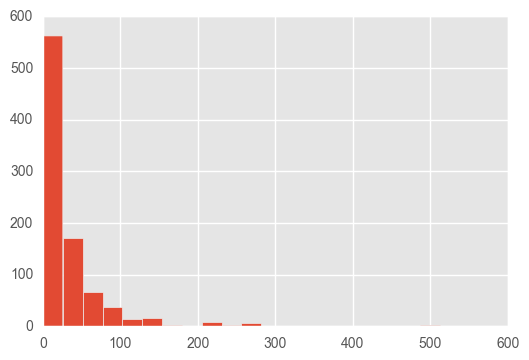

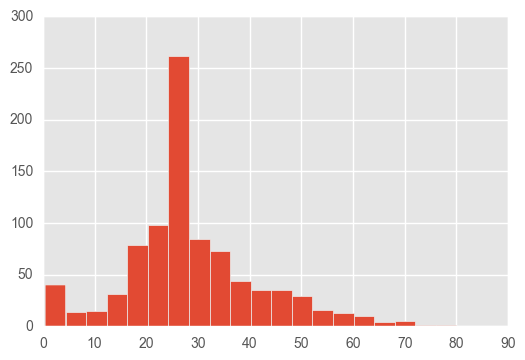

In [23]:
df_titanic_train['Fare'].hist(bins = 20)
plt.show()
df_titanic_train['Age'].hist(bins = 20)
plt.show()

`Age` looks fine, but there seems to be a big skew in `Fare`. I am going to check the column to make sure there are no strange, low values.

In [24]:
df_titanic_train[df_titanic_train['Fare'] < 1].head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,is_southampton,is_cherbourg
178,0,3,1,36.0,0,0,0.0,1,0
262,0,1,1,40.0,0,0,0.0,1,0
270,1,3,1,25.0,0,0,0.0,1,0
276,0,2,1,28.0,0,0,0.0,1,0
301,0,3,1,19.0,0,0,0.0,1,0


It seems like there are quite a few cells with fares of 0. I am going to replace these numbers with the corresponding median of the fare for everyone with the same `Pclass`.

In [25]:
class_one = df_titanic_train[df_titanic_train.Pclass == 1].Fare.median()
class_two = df_titanic_train[df_titanic_train.Pclass == 2].Fare.median()
class_three = df_titanic_train[df_titanic_train.Pclass == 3].Fare.median()
indices = df_titanic_train[df_titanic_train['Fare'] < 1].index
for x in indices:
    if df_titanic_train.loc[x, 'Pclass'] == 1:
        df_titanic_train.loc[x, 'Fare'] = class_one
    if df_titanic_train.loc[x, 'Pclass'] == 2:
        df_titanic_train.loc[x, 'Fare'] = class_two
    if df_titanic_train.loc[x, 'Pclass'] == 3:
        df_titanic_train.loc[x, 'Fare'] = class_three
        
df_titanic_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,is_southampton,is_cherbourg
0,0,3,1,22.0,1,0,7.2500,1,0
1,1,1,0,38.0,1,0,71.2833,0,1
2,1,3,0,26.0,0,0,7.9250,1,0
3,1,1,0,35.0,1,0,53.1000,1,0
4,0,3,1,35.0,0,0,8.0500,1,0


I need to create the X and y datasets and split it into training and test datasets.

In [26]:
X_titan = df_titanic_train[df_titanic_train.columns.tolist()[1:]]
y_titan = df_titanic_train['Survived']
X_titanic_train, X_titanic_test, y_titanic_train, y_titanic_test = train_test_split(X_titan, y_titan, test_size=.3)

Now I am going to fit a model for this dataset. I am going to set n to 8 so the tree does not overflow too much.

In [27]:
four = Tree()
four.fit(X_titanic_train, y_titanic_train, n=8)
print(four)

root:  predictor: Sex | threshold: 0 | # elements: 622
   child:  predictor: Pclass | threshold: 2 | # elements: 221
      grandchild^1:  predictor: Age | threshold: 2.0 | # elements: 123
         grandchild^2:  predictor: Pclass | threshold: 1 | # elements: 2
            grandchild^3:  class of leaf: 0
            grandchild^3:  class of leaf: 1
         grandchild^2:  predictor: Fare | threshold: 13.0 | # elements: 121
            grandchild^3:  predictor: Age | threshold: 50.0 | # elements: 20
               grandchild^4:  predictor: Fare | threshold: 12.35 | # elements: 19
                  grandchild^5:  class of leaf: 1
                  grandchild^5:  predictor: Age | threshold: 24.0 | # elements: 11
                     grandchild^6:  predictor: Age | threshold: 18.0 | # elements: 3
                        grandchild^7:  class of leaf: 1
                        grandchild^7:  class of leaf: 1
                     grandchild^6:  predictor: Age | threshold: 36.0 | # elements: 8
 

In [28]:
titanic_preds = four.predict(X_titanic_test)
metrics(y_titanic_test, titanic_preds)

Confusion Matrix: 
[[154  17]
 [ 34  62]]

Accuracy Score: 
0.808988764045

Precision Score: 
0.801979531376
Recall Score: 
0.773209064327


This seems like a reasonable accuracy score (about 80%). However, there are about 51 misclassified points.

Time to move on to dataset 5.

### Dataset 5

I read in the csv file, create X and y datasets, and split these into training and testing datasets.

In [29]:
dataframe = pd.read_csv("noisy_dataset.csv", index_col = 0)
X_noisy = dataframe[['x_1', 'x_2']]
y_noisy = dataframe['y']
X_noisy_train, X_noisy_test, y_noisy_train, y_noisy_test = train_test_split(X_noisy, y_noisy, test_size=.3)

Now I am going to fit this dataset with multiple different models with different n values.

In [38]:
models_scores = dict()
five = Tree()
for x in range(3, 8):
    five.fit(X_noisy_train, y_noisy_train, n=x)
    noisy_preds = five.predict(X_noisy_test)
    models_scores[x] = accuracy_score(y_noisy_test, noisy_preds)

In [ ]:
Here are the accuracy scores for each n value.

In [39]:
models_scores

{3: 0.7466666666666667,
 4: 0.75666666666666671,
 5: 0.78000000000000003,
 6: 0.78000000000000003,
 7: 0.76666666666666672}

In [40]:
x = list(models_scores.keys())
y = list(models_scores.values())

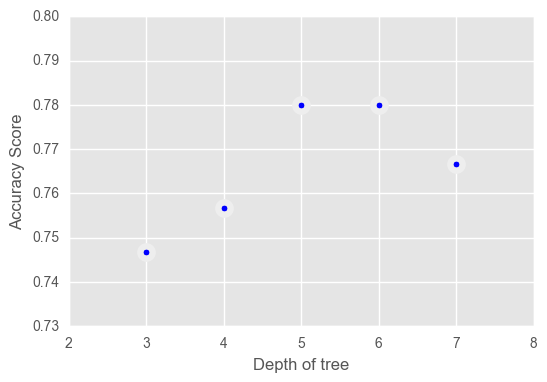

In [41]:
plt.scatter(x, y, linewidths=9)
plt.xlabel("Depth of tree")
plt.ylabel("Accuracy Score")
plt.show()

Based on the graph, it looks like the sixth level has the best accuracy score (almost 80%). In fact, it seems like the seventh level has a lower accuracy score than the sixth level.

## Compare to scikit-learn's `DecisionTreeClassifier` class

It should come as no surprise to you that scikit-learn has a [decision tree class](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier).  Compare your constructed class to theirs in terms of their functionality, what attributes and constructor-arguments does their decision tree class have that yours does not?

Scikit-learn's `DecisionTreeClassifier` class, when compared to ours, accepts more parameters and as a result can be more fine-tuned. Moreover, it provides more advanced functions, such as `score` and `predict_proba`. For example, according to its documentation, `score` returns the mean accuracy on the given test data and labels, and `predict_proba` predicts class probabilities of the input samples.

Here are all the parameters accepted by the `DecisionTreeClassifier` class from `sklearn`:

__init__(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_split=1e-07, class_weight=None, presort=False)

In comparison, our class only accepts the following parameters:
* X dataframe
* y dataframe
* n: maximum depth (stopping condition)

Here are all the fields and methods of the class from `sklearn`:

In [42]:
from sklearn.tree import DecisionTreeClassifier
dir(DecisionTreeClassifier)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_estimator_type',
 '_get_param_names',
 '_validate_X_predict',
 'apply',
 'decision_path',
 'feature_importances_',
 'fit',
 'fit_transform',
 'get_params',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'score',
 'set_params',
 'transform']

## Overfitting and what to do about it

What we saw (hopefully!) in dataset 6 above is called __overfitting__, meaning our model is learning the noise in the training data.  This weakens the models predictive power.  There are many options to reduce overfitting, here are a few.  Implement at least one of them, until you have something that makes your models noticeably better.

* Add a stopping condition: 
 * stop splitting off more nodes when a node reaches either a minimal number of items per node _or_ is a pure node,
 * stop splitting by not allowing any child nodes to go below a minimum number of nodes,
 * stop splitting when you've reached some maximum depth.
* After fitting a deep, overfit tree, use a __validation__ set to _prune_ the tree: remove nodes by rejoining children into parents, then test them against the validation set to see if the pruned tree was better.  Do this until you stop seeing improvements on the validation set.  Here a validation set means a third split of data, different from test and train.  It's different from the training set because you're not training the model on it, but it's also not testing data because you're changing your model based on knowledge gained from the dataset.  It's somewhere in between.  Feel free to ask me about _cross-validation_ as well, and how you could use that instead.  We'll talk about it eventually, but I don't want to add more to this project than is already here.

__Explain to me what you did, and where it shows up in your code (for example, is it in your class definition?).__

We decided to go with a stopping paramater that controls the depth of the tree(i.e. how many layers). Here we added an `"n"` value that controls the limits depth of the tree. The default value we use is 10 (1024 nodes max). It is found in the `fit` method in the Tree class.

## Possible extensions

Here are two extensions of the `DecisionTree` class that you made.  They are entirely optional, so don't feel you need to do them!

* In reality, people use decision trees on a limited basis, typically only when model interpretability is forced by government institutions (so, this happens a lot with banks, for example).  What you normally do is build a __forest__ of trees, that is, a collection of several trees (a common number is 50-500 trees), and then have them vote.  However, if you let your trees build themselves from the same exact datasets each time, they will be roughly the same, and the power of this voting model will be irrelevant.  Thus, one extremely common model is called the __Random Forest__ classifier: give each tree only a subset of the features to train from, don't prune at all (allow them to overfit on that subset), and then have them vote.  This increases the variance of the distribution of tree votes, which helps to average out the errors.  Create a new Python class that builds this classification model.  Note that Random Forests are a current industry favorite (among other things, like support vector machines, boosted trees, and neural networks), meaning if you do this you'll have created a model capable of hacking it with some of the best!

* Scikit-learn's `DecisionTreeClassifier` has a somewhat pretty visualization of the tree that can be exported using the library `GraphViz`.  There are python wrappers to this module, the most common is `pydot`.  Using these libraries, or similar ones, add the functionality of constructing an attractive visualization of your decision tree class.